In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

tqdm.pandas()

In [2]:
## Run the following to compute the mappings for host locations
#!python3 -m scripts.mappings_host_location

## Load Visualization Pipeline for all the periods
## Insert one of the following arguments to run the visualization:
## - sep
## - dic
## - mar
## - jun

#!python3 -m scripts.pipeline_viz sep
#!python3 -m scripts.pipeline_viz dic
#!python3 -m scripts.pipeline_viz mar
#!python3 -m scripts.pipeline_viz jun

#!python3 -m scripts.pipeline_ML sep
#!python3 -m scripts.pipeline_ML dic
#!python3 -m scripts.pipeline_ML mar
#!python3 -m scripts.pipeline_ML jun

# Datasets analysis

## Sep dataset

In [3]:
df_sep = pd.read_csv("data/data_sep/d_listings.csv")
df_sep.shape

(7950, 75)

In [4]:
sep_nas = pd.DataFrame(df_sep.isnull().sum(), columns=["NAs"])
sep_nas.loc[sep_nas["NAs"] > 0, :]

,NAs
description,111
neighborhood_overview,3208
host_location,1754
host_about,3529
host_response_time,829
host_response_rate,829
host_acceptance_rate,535
host_is_superhost,205
host_neighbourhood,3536
neighbourhood,3208


### Drop columns with too many NAs

In [5]:
df_sep.drop(["neighborhood_overview",
             "host_about",
             "host_neighbourhood",
             "neighbourhood",
             "bathrooms",
             "calendar_updated",
             "license",
             "review_scores_accuracy",
             "review_scores_cleanliness",
             "review_scores_checkin",
             "review_scores_communication",
             "review_scores_location",
             "review_scores_value"],
            axis=1,
            inplace=True)

### Drop not useful

In [8]:
df_sep.drop([
    "listing_url",
    "scrape_id",
    "last_scraped",
    "source",
    "name",
    "description",
    "picture_url",
    "host_url",
    "host_name",
    "host_thumbnail_url",
    "host_picture_url",
    "neighbourhood_group_cleansed",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",
    "has_availability",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "calendar_last_scraped",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "instant_bookable",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
],
axis=1,
inplace=True)

df_sep.set_index("id", inplace=True)


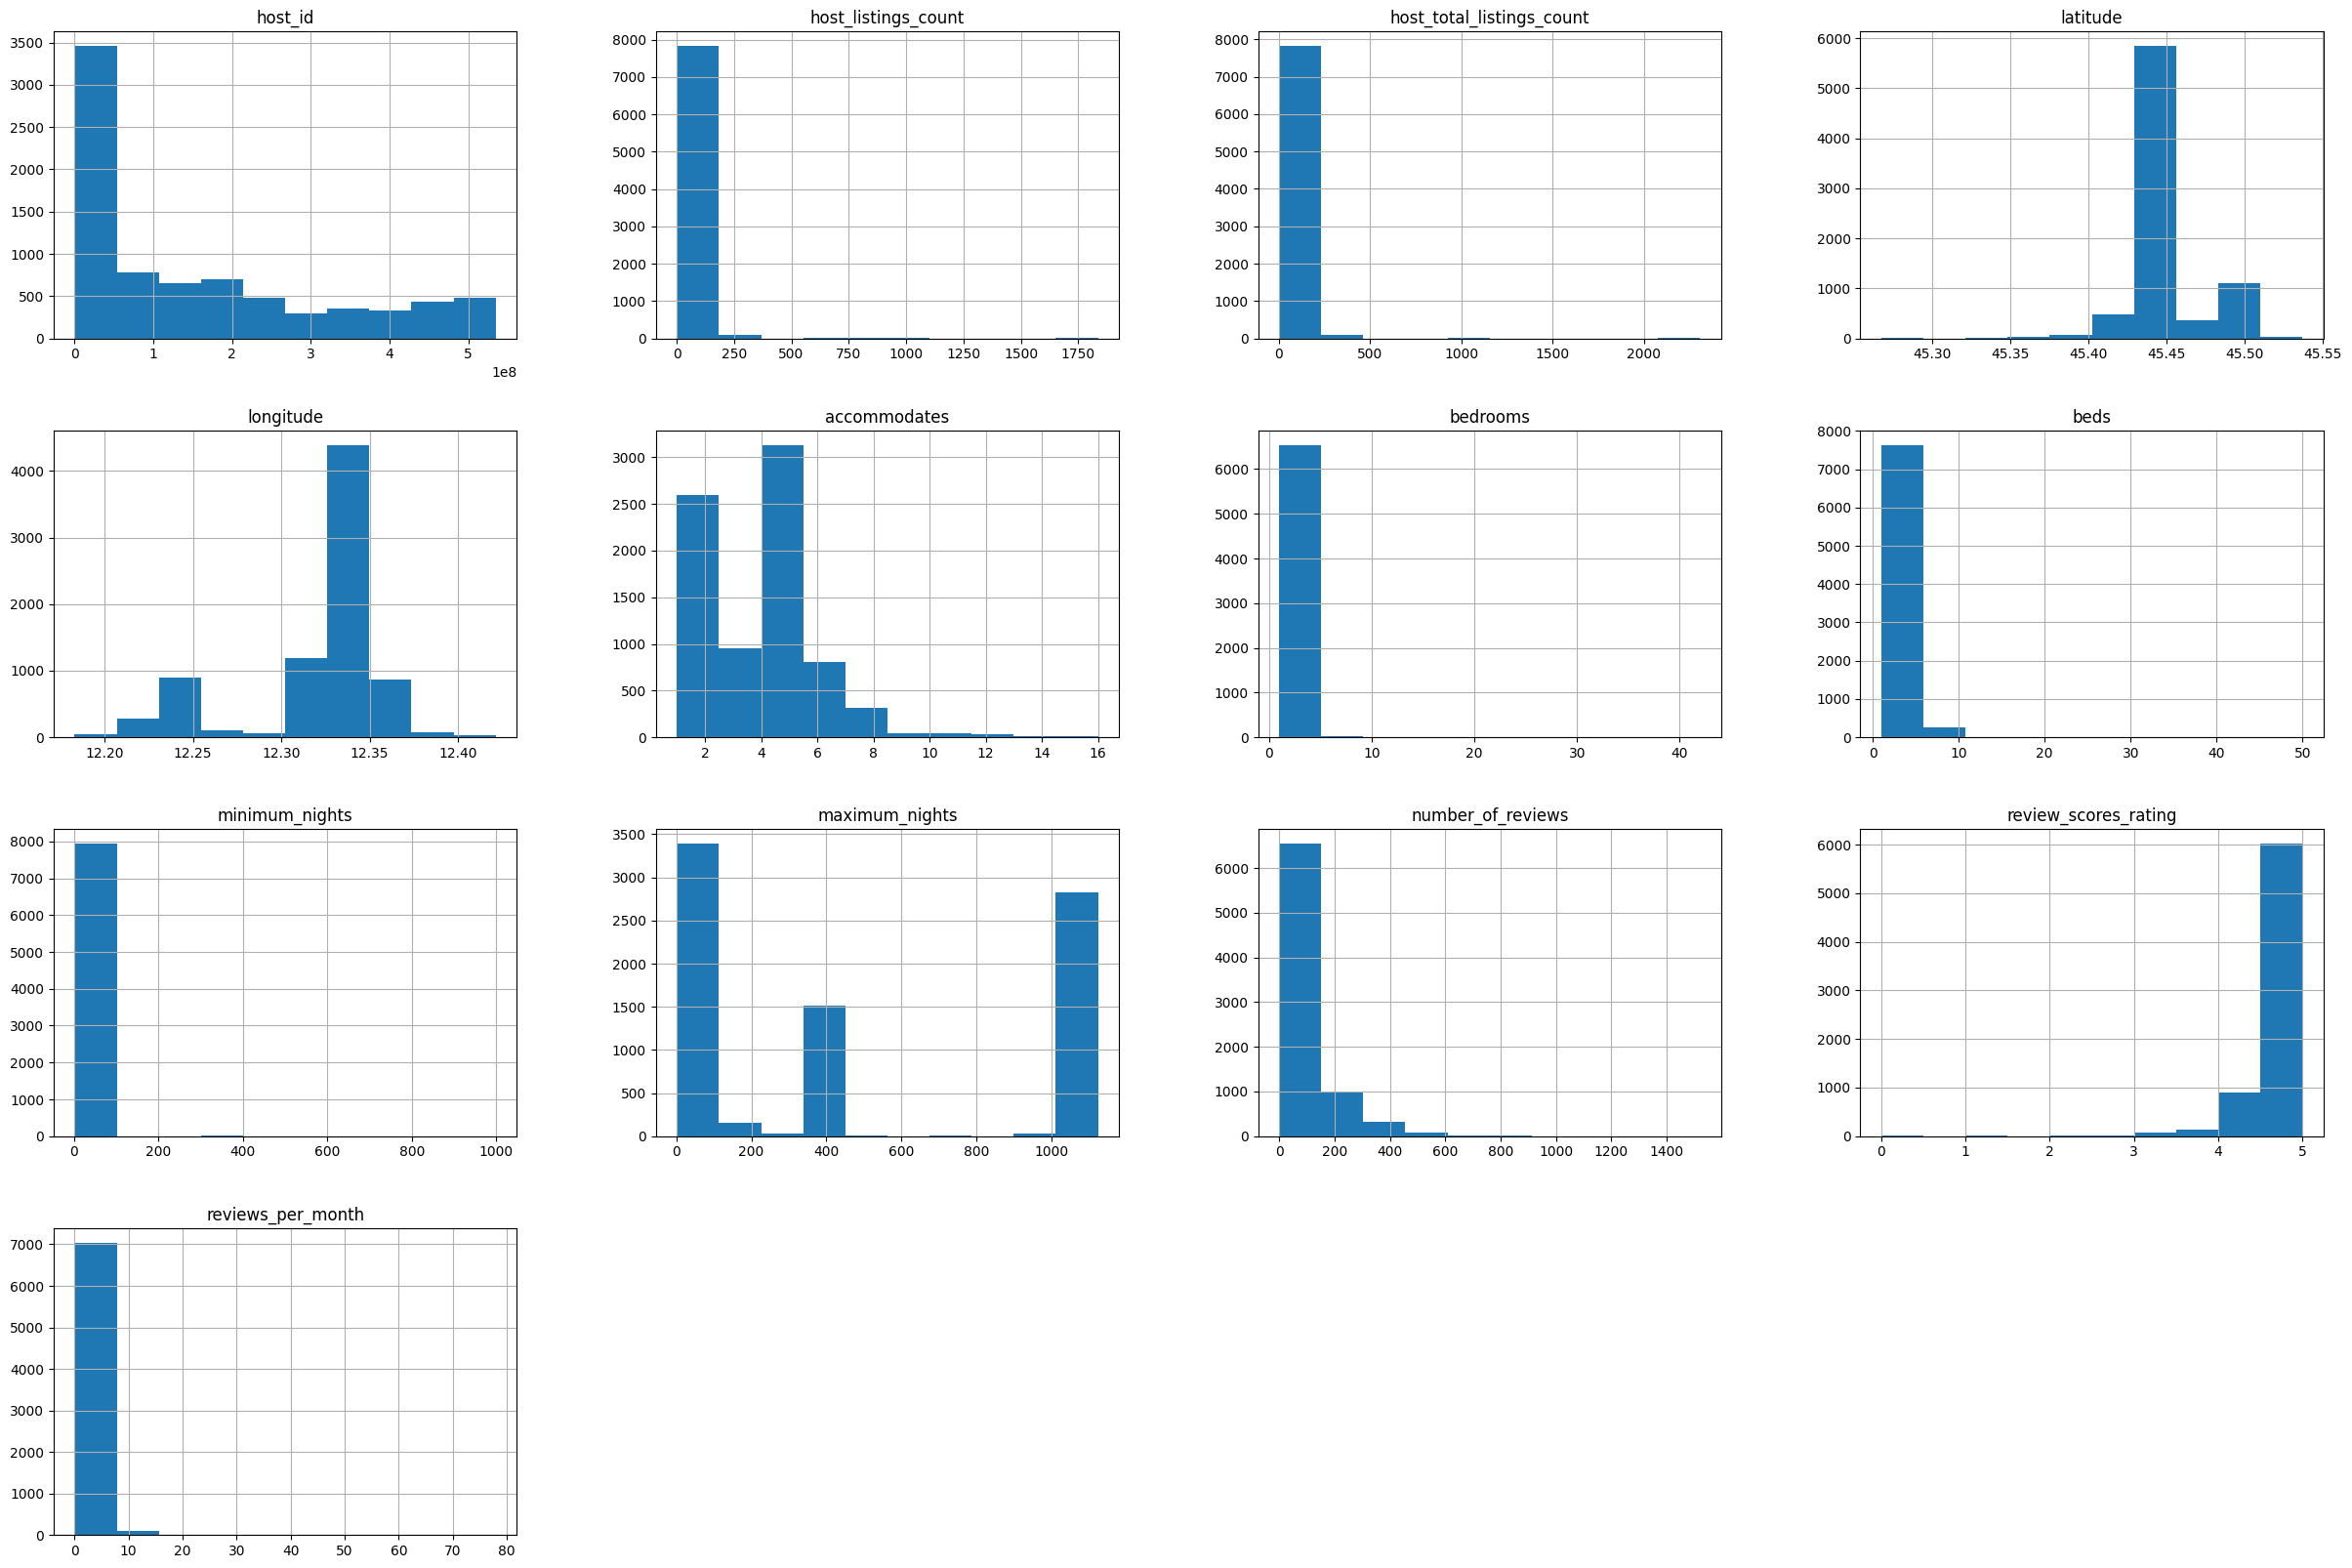

In [9]:
see_histograms = df_sep.copy()

pd.set_option('future.no_silent_downcasting', True)
see_histograms.replace({'f': 0, 't': 1}, inplace=True)

see_histograms.hist(figsize=(30,20));

In [10]:
#df_nas_columns = pd.DataFrame(df_sep.isnull().sum(axis=1), columns=["NAs"])


df_nas_columns = pd.DataFrame({
    'NAs': df_sep.isnull().sum(axis=1),
    'Columns_with_NAs': df_sep.apply(lambda x: ', '.join(x.index[x.isnull()]), axis=1)
})
df_nas_columns.loc[df_nas_columns["NAs"]>4]

,NAs,Columns_with_NAs
id,,
829284975573971493,8,"host_response_time, host_response_rate, host_a..."
22925979,8,"host_response_time, host_response_rate, host_a..."
37198373,6,"host_location, host_acceptance_rate, first_rev..."
731748491112912461,5,"bedrooms, first_review, last_review, review_sc..."
45784539,5,"host_location, first_review, last_review, revi..."
...,...,...
949026541882771236,5,"bedrooms, first_review, last_review, review_sc..."
720853914889671458,5,"bedrooms, first_review, last_review, review_sc..."
740584934427192854,5,"bedrooms, first_review, last_review, review_sc..."


### Drop the rows where more than 5 features are missing

In [25]:
more_than_5_missing = df_nas_columns.loc[df_nas_columns["NAs"]>5, :].index.tolist()
df_sep.drop(more_than_5_missing, inplace=True)
df_sep.shape

KeyError: '[829284975573971493, 22925979, 37198373, 36065811, 27600068, 17689700, 970752396953913336, 30432470, 829252281889497473, 836231436540178802, 35611767, 834202136066435100, 938151177307775271, 54310897, 35505572, 9045303, 681662539185250997, 938096252842983402, 949323951714739866, 19170663, 807684208837043608, 877883129302152343, 850016792584828144, 953405578720288504, 50520630, 10795221, 639669290945609156, 42535922, 675026939779028127, 914342517739225689, 938146613539244104, 953380643417619710, 3603203, 969397623259486124, 47862364, 938141861447113867, 958424743922064382, 959859759659290458, 7397041, 19571245, 22198770, 41745294, 617288024711107485, 2014854, 12900098, 842444842299926246, 842448767203259993, 938144895537892471, 41230237, 41739723, 43797181, 664888510878921811, 45250837, 27539099, 965917520958884422, 938147625406407609, 40699099, 842446479352798682, 842445930389117853, 959875322344980186, 959839163333294956, 559364982878228875, 36372795, 50520154, 866495484506953138, 962442308696915712, 807680416085116912, 842447525774130356, 43797383, 856998614508561337, 48590770, 957070694101986698, 41745595, 44836746, 31850678, 829274497109370137, 638300545340556802, 638403805969773939, 638405224053587919, 44325296, 39430631, 39686632, 40751721, 54310852, 554109000653251610, 933957767034249220, 940349559334194300, 22743540, 36968069, 823007908288694504, 924418129373356515, 924398117683958821, 908449819355594566, 33263782, 904289194736080237, 5084445, 40509016, 943125281485806134, 907256921478950734, 21824763, 946983527970138268, 834178316221644052, 36781912, 352478, 52005886, 40753325, 9233701, 32183486, 36334329, 36334306, 822993737972241831, 42683930, 43621589, 43753717, 554092988304710652, 937642445686357229, 39808007, 779607222158395748, 954829424053217642, 2226056, 23032100, 704823709237371920, 36066436, 554107603599770813, 35505069, 826344287960654608, 12864747, 25205637, 595451807363045433, 33923459, 881772556881832984, 924426459253112636, 606337751482983732, 6488939, 25402893, 27605918, 27615894, 959274243681109298, 6650271, 959420011695072553, 724557091398859840, 16833338, 27617451, 6552897, 8110382, 744760241432823124, 969261133675749660, 5397304, 11352211, 50946544, 583782304739958488, 589783178291354552, 680781964193680561, 45246799, 963050044635105558, 938361691001930141, 885494884138712348, 22549377, 37895918, 39477493, 41258135, 39479715, 44158030, 41524653, 43824956, 692804245589277408, 923657673756857980, 936671874115965325, 936680381082069392, 639667501487485109, 48363527, 663073582026731456, 577211329093488471, 848250865984905644, 848257849711343809, 848254619684096849, 950217651828817672, 8561397, 9817138, 13808536, 41524669, 53606999, 573074131933435142, 893384208471303725, 564129931108385377, 969457161333102855, 842532162835415942, 849972684401372337, 823016630484369401, 8423436, 9053589, 9878674, 22569393, 851933221352829140, 39986180, 45187831, 45333195, 936673095470508101, 21299239, 831759783252209023, 848256432838539649, 13807728, 36678559, 936677563221975212, 28799045, 36066515, 888808605755108641, 35577338, 959144274645126251, 12147337, 51974928, 45269532, 717015756051637627, 26341997, 831691520409327634, 45296632, 37866890, 40748129, 969498170866937575, 37027217, 829232242195913025, 829267154642342531, 829289248201257295, 836234048630554776, 54135456, 625224825362862320, 52109097, 831711271176721766, 45108052, 831718327610589757, 35611685, 47777574, 746134384234632809, 12304004, 733530290707276780, 829245078528604905, 45444597, 6179111, 29603997, 807682586483941230, 836265703905075636, 45399411, 35611837, 49959194, 807675656270226907, 967255599456414774, 47775624, 11267714, 829282157492747911, 7212771, 20880533, 7018697, 13593769, 7979035, 8005560, 8736169, 829274791927562895, 41857160, 836191270362972650, 27336937, 27599571, 936674095956064820, 968025488042039536, 936681045958846435, 936678854154237428] not found in axis'

## Handling amenities

In [12]:
amenities_lists = df_sep["amenities"].tolist()

amenities_counter = {}

for el in amenities_lists:
    for e in el.strip('][').split(', '):
        try:
            amenities_counter[e.strip('"')] += 1
        except:
            amenities_counter[e.strip('"')] = 1

amenities_counter = dict(sorted(amenities_counter.items(), key=lambda item: item[1], reverse=True))


### Remapping amenities into a smaller dictionary

In [13]:
amenities_remapping = {}

#### technology

In [14]:
pattern = r'\b(wifi|internet|ethernet|cable|fibra|dolby|smart|connection|tv|television|netflix|amazon|disney)\b'
regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if regex.search(am):
        amenities_remapping[am] = "technology"

#### Kitchen

In [15]:
pattern = r'\b(kitchen|cooking|grill|cucina|refrigerator|fridge|oven|stove|dish|coffee|espresso|lavazza|dining|breakfast|microonde|microwave|washer|freezer|glasses|toast|baking)\b'
regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if regex.search(am):
        amenities_remapping[am] = "kitchen"


#### Toiletry

In [16]:
pattern = r'\b(hair|capelli|soap|sapone|bidet|shampoo|bathtub|gel|laundry|closet|pillow|blanket|shower)\b'
regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if regex.search(am):
        amenities_remapping[am] = "toiletry"

#### AC/heating

In [17]:
pattern = r'\b(heating|ac|air|conditioning|fan)\b'
regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if regex.search(am):
        amenities_remapping[am] = "AC/heating"


#### Benefits

In [18]:
pattern = r'\b(garden|backyard|skyline|beach|gym|fitness|view|outdoor|balcony|waterfront|bed linen|workspace|aid|luggage|elevator|free|safe|lock|security|bike|estinguisher)\b'
regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if regex.search(am):
        amenities_remapping[am] = "benefits"


#### Other

In [19]:
pattern = r'\b(wifi|internet|ethernet|cable|fibra|dolby|smart|connection|tv|television|netflix|amazon|disney|kitchen|cooking|grill|cucina|refrigerator#|fridge|oven|stove|dish|coffee|espresso|lavazza|dining|breakfast|microonde|microwave|washer|freezer|glasses|toast|baking|hair|capelli|soap|sapone|bidet#|shampoo|bathtub|gel|laundry|closet|pillow|blanket|showers|heating|ac|air|conditioning|fan|garden|backyard|skyline|beach|gym|fitness|view|outdoor#|balcony|waterfront|bed linen|workspace|aid|luggage|elevator|free|safe|lock|security|bike)\b'

regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if not regex.search(am):
        amenities_remapping[am] = "other"



### Remapping amenities in dataframe

In [20]:
def unwrap_remap_amenities(value):
    element = [e.strip('"') for e in value.strip('][').split(', ')]
    remapped_amenities = (pd.Series(element)).map(amenities_remapping)
    return remapped_amenities.tolist()

df_sep["amenities"] = df_sep["amenities"].apply(unwrap_remap_amenities)


In [22]:
def return_amenity_counter(row):
    amenities = ["AC/heating", "technology", "kitchen", "benefits", "toiletry", "other"]
    counts = {amenity: row["amenities"].count(amenity) for amenity in amenities}
    for amenity, count in counts.items():
        row[f'amenities_{amenity}'] = count
    return row

df_sep = df_sep.apply(lambda x: return_amenity_counter(x), axis=1)

### NEXT

In [23]:
df_sep

,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,first_review,last_review,review_scores_rating,reviews_per_month,amenities_AC/heating,amenities_technology,amenities_kitchen,amenities_benefits,amenities_toiletry,amenities_other
id,,,,,,,,,,,,,,,,,,,,,
27491536,185612295,2018-04-22,"Venice, Italy",within a day,50%,32%,f,6,16,"['email', 'phone']",...,2018-10-01,2023-05-28,4.00,0.03,2,1,1,0,1,3
33146077,184936719,2018-04-18,"Venice, Italy",within a day,100%,55%,f,2,5,"['email', 'phone']",...,2019-11-04,2019-11-04,0.00,0.02,1,2,2,1,1,11
603168,2985972,2012-07-19,"Venice, Italy",within an hour,100%,100%,t,3,3,"['email', 'phone']",...,2012-10-27,2023-08-11,4.75,3.84,2,2,3,2,2,8
27948475,201491444,2018-07-11,NaN,within an hour,100%,0%,f,2,2,"['email', 'phone']",...,2018-09-05,2019-04-07,5.00,0.21,2,1,2,1,2,4
11530067,60807005,2016-02-28,"Venice, Italy",within an hour,100%,100%,t,1,1,"['email', 'phone']",...,2016-03-30,2023-08-16,4.92,4.66,2,1,10,6,5,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41616557,41684464,2015-08-17,NaN,within an hour,94%,100%,f,10,12,"['email', 'phone']",...,2020-09-14,2023-08-28,4.73,0.30,2,2,3,0,2,7
759085255211253914,23825708,2014-11-16,"Milan, Italy",within an hour,100%,96%,f,6,7,"['email', 'phone', 'work_email']",...,2023-04-13,2023-08-13,4.80,1.04,2,4,11,5,5,26
960627432245519880,419556671,2021-08-22,NaN,within an hour,93%,78%,f,5,5,"['email', 'phone']",...,NaN,NaN,NaN,NaN,1,2,2,1,0,0


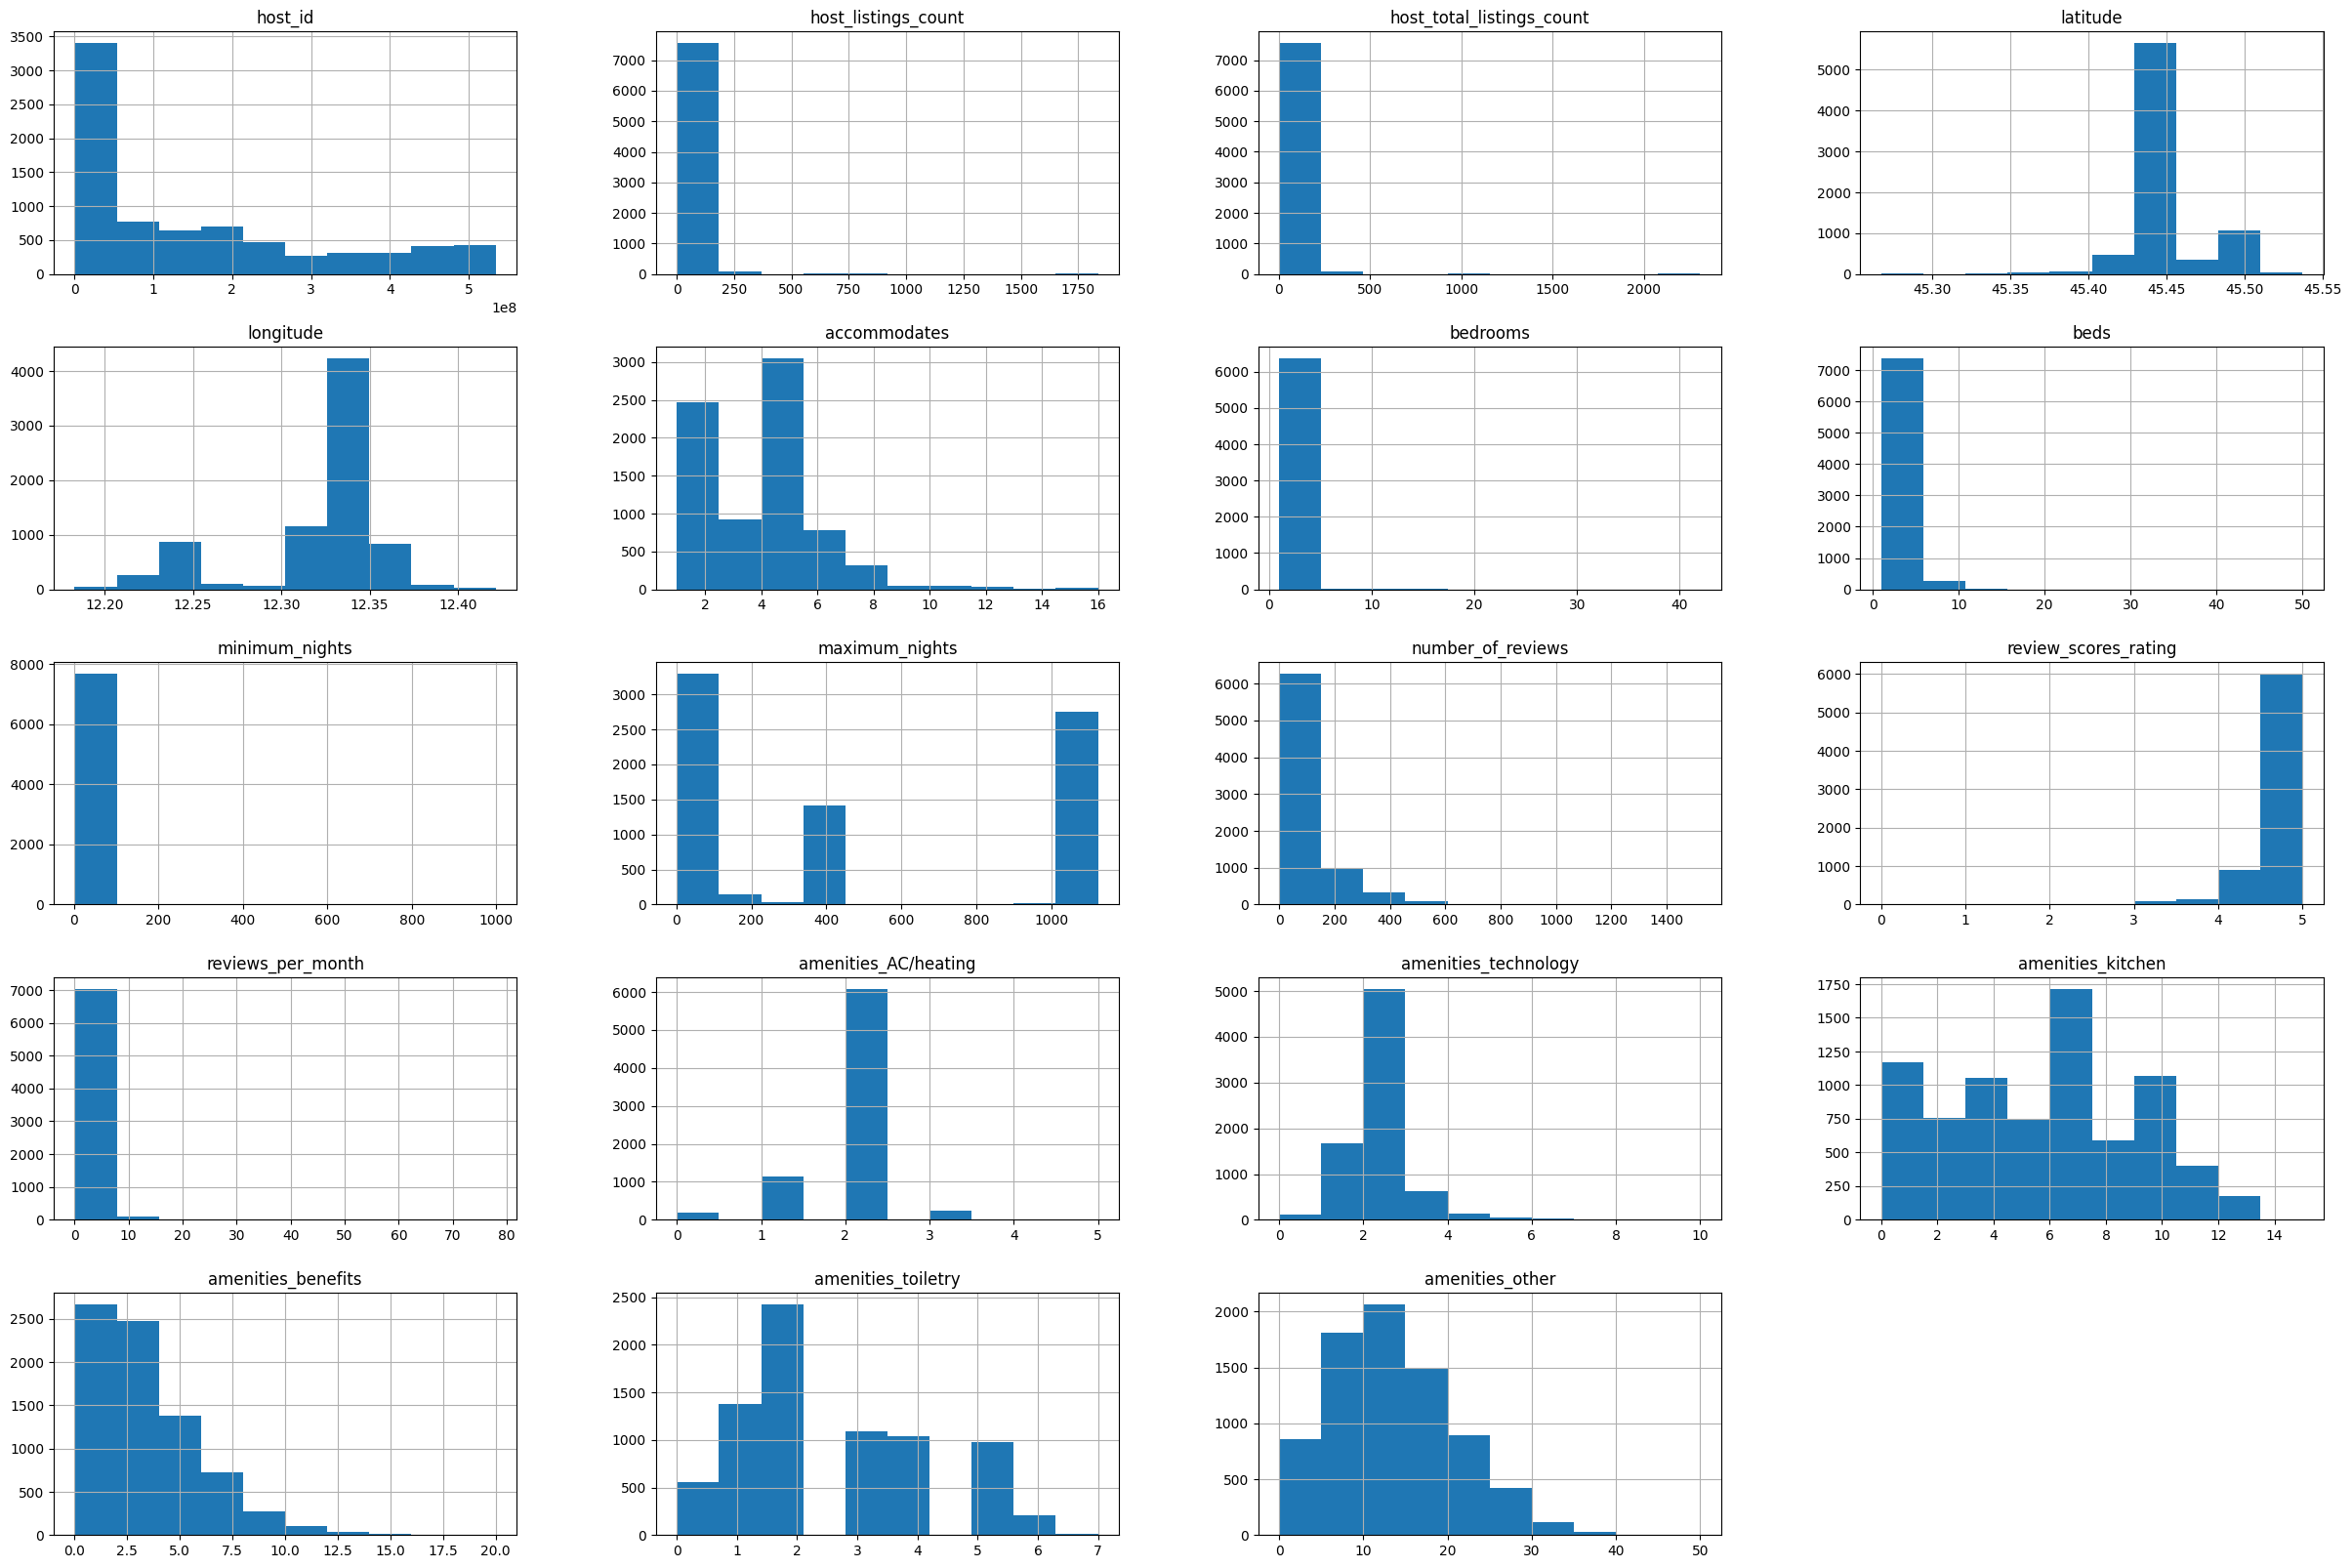

In [24]:
see_histograms = df_sep.copy()

pd.set_option('future.no_silent_downcasting', True)
see_histograms.replace({'f': 0, 't': 1}, inplace=True)

see_histograms.hist(figsize=(30,20));
